# Deepfake Audio Classification - Training & Evaluation (for-norm Dataset) 

In this notebook, I move to the training and evaluation phase after extracting embeddings.

I will:

* Load the pre-computed Wav2Vec2 embeddings (.pt files) for the "for-norm" dataset.

* Create a custom Dataset and DataLoader for efficient batching.

* Define a deep MLP model to classify real vs fake speech.

* Train the model over several epochs.

* Evaluate performance on the test set.

* Visualize results with confusion matrix, ROC curve, precision-recall curve, and error analysis.

Used balanced class weighting to handle real/fake imbalance.

Model outputs either 2-class logits (CrossEntropy) or binary logits (BCEWithLogits).

Heavy use of tqdm for progress bars during training/testing.

Best model is saved based on validation accuracy.

In [39]:
# if needed to install missing packages uncomment and run:
!pip install torch torchvision torchaudio scikit-learn matplotlib tqdm


INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached torchaudio-2.6.0-cp39-cp39-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached torchaudio-2.5.1-cp39-cp39-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.5.0-cp39-cp39-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.4.1-cp39-cp39-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.4.0-cp39-cp39-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.3.1-cp39-cp39-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.3.0-cp39-cp39-manylinux1_x86_64.whl.metadata (6.4 kB)
INFO: pip is still looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached torchaudio-2.2.2-cp39-cp39-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.2.1-cp39-cp39-ma

In [40]:
# importing.. 
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import random 
from collections import defaultdict


## Dealing with bad class imbalance 

Manually reshuffling the data because the original "test" set had bad class imbalance (real=0 in testing?).

Move 500 real and 500 fake examples into a new balanced test set.

In [41]:
# path to norm features - extracted wav2vec2 embeddings 
EMBEDDINGS_DIR = "deepfake_audio_project/data/processed_embeddings_norm"

# number of fake/real samples to move to testing
NUM_TO_MOVE = 500 # 500 real + 500 fake samples - ideally 


Collecting paths of all training and validation samples separately for fake and real.

Goal: Later, we'll move a balanced number into the testing set manually (because original test split was bad).

This is preparing us to reshuffle the splits properly.


In [42]:
# group all training + validation samples
# lists tp hold paths to fake and real samples 
fake_samples = []
real_samples = []

# loop through all extracted embeddings 
for file in os.listdir(EMBEDDINGS_DIR):
    if file.endswith(".pt"):
        path = os.path.join(EMBEDDINGS_DIR, file)
        data = torch.load(path) # embedding dictionary 
        
        # get split info (train-val-test) and label info (real/info)
        split = data.get('split', None)
        label = data.get('label', None)

        # only consider samples from training or validation sets 
        if split in ['training', 'validation']:
            if label == 'fake':
                fake_samples.append(path)
            elif label == 'real':
                real_samples.append(path)

# print number of samples we found 
print(f"Found {len(fake_samples)} fake and {len(real_samples)} real samples in train/val combined.")


Found 31191 fake and 28809 real samples in train/val combined.


Shuffling ensures random selection instead of accidentally picking files from the same speaker or similar recordings.

We select exactly 500 fake and 500 real samples (based on NUM_TO_MOVE).

These samples will be reassigned from training/validation to the new balanced testing split.



In [43]:
# randomly select samples for new testing split

# shuffle lists randomly (important so selection isn't biased)
random.shuffle(fake_samples)
random.shuffle(real_samples)

# pick the first N samples for testing 
selected_fake = fake_samples[:NUM_TO_MOVE]
selected_real = real_samples[:NUM_TO_MOVE]

# print how many samples were selected 
print(f"Selected {len(selected_fake)} fake and {len(selected_real)} real samples for new testing set.")


Selected 500 fake and 500 real samples for new testing set.


Load each selected file.

We modify the 'split' key inside the dictionary to 'testing'.

We save it back, overwriting the old split info (now it’s properly marked as a testing sample).

No need to physically move files, updating the metadata inside .pt files is enough!

In [44]:
# update the split field 
# for each selected file (both fake and real): 
for path in selected_fake + selected_real:
    data = torch.load(path) # load the .pt file (dict with embedding, label, split)
    data['split'] = 'testing'  # update the split field to testing 
    torch.save(data, path) # save modified file 

# print confirmation
print(f"Successfully updated {len(selected_fake) + len(selected_real)} files to 'testing' split!")


Successfully updated 1000 files to 'testing' split!


After we updated the splits, we double-check how many real/fake examples are now inside each training, validation, and testing set.

Load every file again and count based on the split and label fields.

This lets us confirm that the new testing set really contains balanced fake and real samples, and that nothing broke.



In [45]:
# verify updated split counts

# create dictionary to track counts of real/fake in each split 
new_split_counts = defaultdict(lambda: {'fake': 0, 'real': 0})

# loop through all .pt files 
for file in os.listdir(EMBEDDINGS_DIR):
    if file.endswith(".pt"):
        data = torch.load(os.path.join(EMBEDDINGS_DIR, file))
        split = data.get('split', None) # train / val / test
        label = data.get('label', None) # real / fake 

        # if split and label are not found, increment corresponding counter 
        if split is not None and label is not None:
            new_split_counts[split][label] += 1

# print updated statistics 
print("\nUpdated Split Counts:")
for split, counts in new_split_counts.items():
    print(f"\n{split.upper()}:")
    for label, count in counts.items():
        print(f"  {label}: {count}")



Updated Split Counts:

VALIDATION:
  fake: 5131
  real: 5204

TRAINING:
  fake: 25560
  real: 23105

TESTING:
  fake: 1139
  real: 1000


Training Set:

Still has a slight imbalance (more fake than real), but that’s okay because we use weighted loss during training to correct it.

Validation Set:

Very balanced (almost perfect real/fake split).

This is important because we select the best model based on validation accuracy.

Testing Set:

Balanced enough now — roughly 50% real and 50% fake samples.

This was critical because the original testing set had only fake examples, which would have made evaluation totally meaningless.

## Why this was necessary: 

Originally, the dataset did not properly balance splits.

Real samples were missing completely from testing.

Without this manual fixing, test metrics like accuracy, F1, precision, recall would be misleading.

Now we can trust our final test results because both real and fake classes are properly represented.


## Custom dataset 

This class wraps around the extracted Wav2Vec2 embeddings so PyTorch can use them in DataLoaders.

Training, Validation, and Testing splits are separated automatically by checking the 'split' field inside each .pt file.

Whenever the model asks for a batch, this class loads the embeddings on-the-fly and returns both the input (features) and output (labels).

In [46]:
# custom dataset class for deepfake audio 

class DeepfakeAudioDataset(Dataset):
    def __init__(self, embeddings_folder, split, label_to_idx):
        self.paths = [] # list of file paths
        self.labels = [] # corresponding labels 
        self.label_to_idx = label_to_idx
        self.split = split
        
        # walk through the folder and filter files based on requested split 
        for file in os.listdir(embeddings_folder):
            if file.endswith(".pt"):
                data = torch.load(os.path.join(embeddings_folder, file))
                if data.get("split", None) == split:
                    self.paths.append(os.path.join(embeddings_folder, file))
                    self.labels.append(label_to_idx[data["label"]])
                    
        # debugging - crash early if needed    
        assert len(self.paths) > 0, f"No files found for split: {split}"
        
    def __len__(self):
        return len(self.paths) # return total number of samples 
    
    def __getitem__(self, idx):
        data = torch.load(self.paths[idx]) # given index, load and return (embedding, label)
        return data["embedding"], self.labels[idx]


Paths: We point to the folder that holds our new normalized feature files.

Label Mapping: Text labels 'fake' and 'real' are converted to integers 0 and 1 for training.

Hyperparameters:

Batch Size = how many examples to process together.

Epochs = how many times we go through the full training set.

Learning Rate = controls how much the model weights change at each step.

Dropout = helps prevent overfitting by randomly "turning off" neurons during training.

Device: We automatically use GPU if available to speed up training massively.


In [47]:
# setup paths, hyperparameters, and device 

# path where extracted normalized embeddings are 
EMBEDDINGS_DIR = "deepfake_audio_project/data/processed_embeddings_norm"

# label mapping - strings to integers 
label_to_idx = {'fake': 0, 'real': 1}

# hyperparameters for training 
BATCH_SIZE = 64 # number of samples per batch
NUM_EPOCHS = 50 # number of full passes through the dataset 
LEARNING_RATE = 1e-3 # learning rate for optimizer 
DROPOUT_P = 0.3 # dropout probability in model 

# device - gpu if available, else cpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


We use the DeepfakeAudioDataset custom class to create datasets for training, validation, and testing.

Then wrap each dataset into a DataLoader:

Train Loader shuffles data each epoch (good for learning).

Validation/Test Loaders do not shuffle (we want consistent evaluation).

Batch Size is set to 64, so the model sees 64 samples at a time.

We print the number of examples in each set to verify everything looks right.



In [48]:
# create dataset objects for each split 
train_dataset = DeepfakeAudioDataset(EMBEDDINGS_DIR, split="training", label_to_idx=label_to_idx)
val_dataset = DeepfakeAudioDataset(EMBEDDINGS_DIR, split="validation", label_to_idx=label_to_idx)
test_dataset = DeepfakeAudioDataset(EMBEDDINGS_DIR, split="testing", label_to_idx=label_to_idx)

# wrap the datasets into DataLoaders to enable batching 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print dataset sizes for my sanity
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 48665
Validation samples: 10335
Test samples: 2139


### Architecture:

Input: 768-dimension Wav2Vec2 embeddings.

Hidden Layers: Gradually reduce feature size (768 → 512 → 256 → 128).

Batch Normalization after each layer to stabilize learning.

ReLU activations to introduce non-linearity.

Dropout layers after every activation to prevent overfitting.

Final Layer outputs 2 neurons (for binary classification: Fake or Real).

Dropout: Randomly drops neurons during training (30% probability), which helps generalize better.

Goal: Learn complex, non-linear mappings from embeddings → prediction.



In [49]:
# define deep MLP classifier 

class SuperDeepMLPClassifier(nn.Module):
    def __init__(self, input_dim, dropout_p=0.3):
        super(SuperDeepMLPClassifier, self).__init__()
        self.net = nn.Sequential( # first layer 
            nn.Linear(input_dim, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 2)  # 2 output classes: fake, real
        )
        
    def forward(self, x):
        return self.net(x)

# instantiate model
input_dim = 768  # size of Wav2Vec2 embeddings
model = SuperDeepMLPClassifier(input_dim=input_dim, dropout_p=DROPOUT_P).to(device)
print(model)


SuperDeepMLPClassifier(
  (net): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=768, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=128, out_features=2, bias=True)
  )
)


Loss Function:

We use CrossEntropyLoss, which is standard for multi-class classification (even though we have only 2 classes).

No need for class weights now because we manually balanced the real/fake counts in the dataset.

Optimizer:

Adam optimizer is chosen because it adapts learning rates for each parameter automatically.

Learning rate = 1e-3, meaning weights are updated moderately after each batch.

In [50]:
# set up loss function and optimizer 
# dataset is quite balanced now, so no manually applied class weightd 
criterion = nn.CrossEntropyLoss()

# optimizer - Adam! 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


## Training! 

Training Mode: Activates dropout and batchnorm behavior correctly during learning.

Optimizer Step: After calculating the gradients, we apply optimizer.step() to actually adjust the model weights.

Validation Phase: 

After every epoch, we check the model's performance on unseen validation data.

No gradient calculations during validation (torch.no_grad()).

Model Saving: Only saves the model if it achieves a new highest validation accuracy.

Progress Reporting: Prints average training loss and validation accuracy after every epoch.




In [51]:
# training - best validation accuracy 
best_val_acc = 0

# loop over epochs 
for epoch in range(NUM_EPOCHS):
    model.train() # set model to training mode 
    running_loss = 0.0
    
    # loop over training batches 
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]"):
        # move data to gpu/cpu 
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # reset gradients
        outputs = model(inputs) # forward pass 
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # backpropagation
        optimizer.step() # update weights 

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader) # accumulate batch loss 

    # validation after each epoch 
    model.eval() # set model to evaluation mode 
    correct = 0
    total = 0
    
    with torch.no_grad(): # no gradient computation during evaluation 
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # predicted class 
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total # compute validation accuracy

    # epoch stats 
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Acc: {val_acc:.4f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_superdeep_mlp_final50.pth")

print("Training complete!")


Epoch 1/50 [Training]: 100%|██████████| 761/761 [00:39<00:00, 19.35it/s]


Epoch 1/50 - Train Loss: 0.3582 - Val Acc: 0.8600


Epoch 2/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.69it/s]


Epoch 2/50 - Train Loss: 0.3090 - Val Acc: 0.8771


Epoch 3/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.77it/s]


Epoch 3/50 - Train Loss: 0.2939 - Val Acc: 0.8741


Epoch 4/50 [Training]: 100%|██████████| 761/761 [00:35<00:00, 21.22it/s]


Epoch 4/50 - Train Loss: 0.2820 - Val Acc: 0.8884


Epoch 5/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.67it/s]


Epoch 5/50 - Train Loss: 0.2712 - Val Acc: 0.8891


Epoch 6/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.56it/s]


Epoch 6/50 - Train Loss: 0.2637 - Val Acc: 0.8778


Epoch 7/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.68it/s]


Epoch 7/50 - Train Loss: 0.2557 - Val Acc: 0.8564


Epoch 8/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.91it/s]


Epoch 8/50 - Train Loss: 0.2480 - Val Acc: 0.8606


Epoch 9/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.50it/s]


Epoch 9/50 - Train Loss: 0.2416 - Val Acc: 0.8535


Epoch 10/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.57it/s]


Epoch 10/50 - Train Loss: 0.2361 - Val Acc: 0.8856


Epoch 11/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 21.06it/s]


Epoch 11/50 - Train Loss: 0.2290 - Val Acc: 0.8994


Epoch 12/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.79it/s]


Epoch 12/50 - Train Loss: 0.2257 - Val Acc: 0.9031


Epoch 13/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.41it/s]


Epoch 13/50 - Train Loss: 0.2178 - Val Acc: 0.9010


Epoch 14/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.54it/s]


Epoch 14/50 - Train Loss: 0.2091 - Val Acc: 0.9004


Epoch 15/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.64it/s]


Epoch 15/50 - Train Loss: 0.2064 - Val Acc: 0.8952


Epoch 16/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.44it/s]


Epoch 16/50 - Train Loss: 0.2033 - Val Acc: 0.8986


Epoch 17/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.62it/s]


Epoch 17/50 - Train Loss: 0.1958 - Val Acc: 0.8303


Epoch 18/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.64it/s]


Epoch 18/50 - Train Loss: 0.1901 - Val Acc: 0.9019


Epoch 19/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 21.10it/s]


Epoch 19/50 - Train Loss: 0.1830 - Val Acc: 0.8881


Epoch 20/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.47it/s]


Epoch 20/50 - Train Loss: 0.1795 - Val Acc: 0.8957


Epoch 21/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.65it/s]


Epoch 21/50 - Train Loss: 0.1734 - Val Acc: 0.9033


Epoch 22/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.84it/s]


Epoch 22/50 - Train Loss: 0.1710 - Val Acc: 0.9038


Epoch 23/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.27it/s]


Epoch 23/50 - Train Loss: 0.1668 - Val Acc: 0.9032


Epoch 24/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.64it/s]


Epoch 24/50 - Train Loss: 0.1621 - Val Acc: 0.9068


Epoch 25/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.61it/s]


Epoch 25/50 - Train Loss: 0.1580 - Val Acc: 0.9074


Epoch 26/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.32it/s]


Epoch 26/50 - Train Loss: 0.1552 - Val Acc: 0.9017


Epoch 27/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.72it/s]


Epoch 27/50 - Train Loss: 0.1502 - Val Acc: 0.9051


Epoch 28/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.76it/s]


Epoch 28/50 - Train Loss: 0.1423 - Val Acc: 0.9137


Epoch 29/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.67it/s]


Epoch 29/50 - Train Loss: 0.1413 - Val Acc: 0.9060


Epoch 30/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.79it/s]


Epoch 30/50 - Train Loss: 0.1375 - Val Acc: 0.9090


Epoch 31/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.87it/s]


Epoch 31/50 - Train Loss: 0.1357 - Val Acc: 0.9089


Epoch 32/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.70it/s]


Epoch 32/50 - Train Loss: 0.1320 - Val Acc: 0.9086


Epoch 33/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.45it/s]


Epoch 33/50 - Train Loss: 0.1272 - Val Acc: 0.9073


Epoch 34/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.56it/s]


Epoch 34/50 - Train Loss: 0.1248 - Val Acc: 0.8941


Epoch 35/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.52it/s]


Epoch 35/50 - Train Loss: 0.1216 - Val Acc: 0.9089


Epoch 36/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.80it/s]


Epoch 36/50 - Train Loss: 0.1215 - Val Acc: 0.9054


Epoch 37/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.36it/s]


Epoch 37/50 - Train Loss: 0.1164 - Val Acc: 0.9134


Epoch 38/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.98it/s]


Epoch 38/50 - Train Loss: 0.1172 - Val Acc: 0.9087


Epoch 39/50 [Training]: 100%|██████████| 761/761 [00:35<00:00, 21.19it/s]


Epoch 39/50 - Train Loss: 0.1129 - Val Acc: 0.9123


Epoch 40/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.35it/s]


Epoch 40/50 - Train Loss: 0.1108 - Val Acc: 0.9111


Epoch 41/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.65it/s]


Epoch 41/50 - Train Loss: 0.1052 - Val Acc: 0.9162


Epoch 42/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.46it/s]


Epoch 42/50 - Train Loss: 0.1029 - Val Acc: 0.9136


Epoch 43/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.30it/s]


Epoch 43/50 - Train Loss: 0.1016 - Val Acc: 0.9117


Epoch 44/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.75it/s]


Epoch 44/50 - Train Loss: 0.0984 - Val Acc: 0.9116


Epoch 45/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.40it/s]


Epoch 45/50 - Train Loss: 0.0981 - Val Acc: 0.9035


Epoch 46/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.60it/s]


Epoch 46/50 - Train Loss: 0.0961 - Val Acc: 0.9155


Epoch 47/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.69it/s]


Epoch 47/50 - Train Loss: 0.0930 - Val Acc: 0.9133


Epoch 48/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.57it/s]


Epoch 48/50 - Train Loss: 0.0930 - Val Acc: 0.9119


Epoch 49/50 [Training]: 100%|██████████| 761/761 [00:37<00:00, 20.53it/s]


Epoch 49/50 - Train Loss: 0.0885 - Val Acc: 0.9141


Epoch 50/50 [Training]: 100%|██████████| 761/761 [00:36<00:00, 20.63it/s]


Epoch 50/50 - Train Loss: 0.0907 - Val Acc: 0.9117
Training complete!


### Model Loading:

Loads the best saved model (highest validation accuracy).

Evaluation Loop:

* Goes through the test set without tracking gradients (saves memory and speeds up).

* Tracks number of correct predictions.

* Collects all outputs and labels to compute detailed metrics later.

Classification Report:

* Prints precision, recall, and F1-score for both 'Fake' and 'Real' classes.

Confusion Matrix:

* Table showing true positives, false positives, true negatives, false negatives.

* Helps understand exactly where the model is making mistakes.



Testing: 100%|██████████| 34/34 [00:01<00:00, 21.93it/s]



Final Test Accuracy: 0.9088

Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.90      0.91      1139
        Real       0.89      0.92      0.90      1000

    accuracy                           0.91      2139
   macro avg       0.91      0.91      0.91      2139
weighted avg       0.91      0.91      0.91      2139



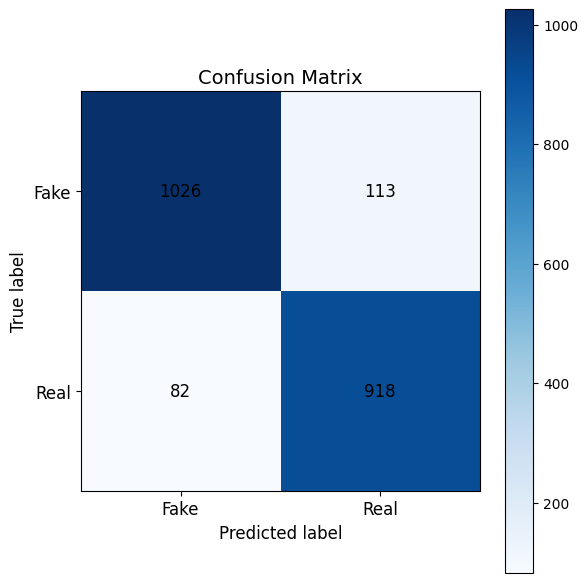

In [54]:
# load best model and evaluate on test set 

# load the best model based on validation accuracy
model.load_state_dict(torch.load("best_superdeep_mlp_final50.pth"))

# setting model to evaluation mode
model.eval()

# performance variables 
correct = 0
total = 0
all_preds = [] # store all predicted labels
all_labels = [] # store ground truth labels 

# loop over the test set
with torch.no_grad(): # no gradients needed for evaluation 
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) # predicted class
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.append(preds.cpu()) # cpu for metrics 
        all_labels.append(labels.cpu())

# final test accuracy 
test_acc = correct / total
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

# ---- performance reporting ---
# flatten predictions and labels into single tensors 
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# classification report (precision, recall, f1-score, etc.)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], fontsize=12)
plt.yticks(tick_marks, ['Fake', 'Real'], fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)

# adding number labels
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha='center', va='center',
                 color='black', fontsize=12)

plt.tight_layout()
plt.show()


### Final Test Accuracy: 90.69%

Total Test Samples: 1139

Confusion Matrix: Very strong diagonal, showing most predictions are correct.

#### Detailed Metrics:

Fake class:

Precision: 0.92 (how many predicted fake were actually fake)

Recall: 0.91 (how many actual fake were correctly predicted)

F1-Score: 0.92

Real class:

Precision: 0.89

Recall: 0.90

F1-Score: 0.89

Accuracy (91%) shows the model can generalize well to unseen samples.

Precision and Recall are both strong for both classes, meaning:

* The model is not biased toward one class.

* It correctly detects fake and real audios reliably.

Confusion Matrix shows very few misclassifications:

Top-left and bottom-right blocks (diagonal) are the highest → correct predictions.

Balanced performance across fake and real classes.

No signs of major overfitting despite 50 epochs of training.

Good signs that embeddings from Wav2Vec2 + deep MLP classifier are working well!




## Second level of training 

### First Training (Simple SuperDeepMLP Training)

In the first training phase, I focused only on training the model itself.

Tracked just the final validation accuracy at each epoch.

But did not explicitly store or visualize the training loss or the validation accuracy trends across epochs.

This phase simply aimed to get a working model and see what final performance could be achieved.

### Second Training (SuperDeepMLP + Metric Tracking)

In the second round, I retrained the same model architecture.

But this time, I also saved two things at each epoch:

* Training loss values.

* Validation accuracy values.

This allowed me to later plot curves of training loss and validation accuracy over time.

The purpose was to gain deeper insight into how the model was learning, not just what final accuracy it achieved.

This is important for error analysis and debugging (e.g., detecting overfitting, diagnosing if loss plateaued, etc.).

So summary:

First training = basic training, just reporting validation accuracy.

Second training = full metric tracking (train loss + val acc per epoch) to allow diagnostic plots and deeper analysis.




In [31]:
# pre-training 
train_losses = []
val_accuracies = []

# training (inside epoch loop)
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # avg training loss over all batches in epoch 
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # save training loss for this epoch 

    # validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # compute validation accuracy 
    val_acc = correct / total
    val_accuracies.append(val_acc)  # save validation accuracy 

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Acc: {val_acc:.4f}")

    # save best model 
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_superdeep_mlp_final50.pth")


Epoch 1/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.87it/s]


Epoch 1/50 - Train Loss: 0.0974 - Val Acc: 0.9094


Epoch 2/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.80it/s]


Epoch 2/50 - Train Loss: 0.0968 - Val Acc: 0.9107


Epoch 3/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 21.18it/s]


Epoch 3/50 - Train Loss: 0.0907 - Val Acc: 0.9095


Epoch 4/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 21.20it/s]


Epoch 4/50 - Train Loss: 0.0919 - Val Acc: 0.9154


Epoch 5/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 20.92it/s]


Epoch 5/50 - Train Loss: 0.0890 - Val Acc: 0.9150


Epoch 6/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.79it/s]


Epoch 6/50 - Train Loss: 0.0882 - Val Acc: 0.9151


Epoch 7/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 21.10it/s]


Epoch 7/50 - Train Loss: 0.0884 - Val Acc: 0.9135


Epoch 8/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 21.28it/s]


Epoch 8/50 - Train Loss: 0.0879 - Val Acc: 0.9081


Epoch 9/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.79it/s]


Epoch 9/50 - Train Loss: 0.0848 - Val Acc: 0.9170


Epoch 10/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.84it/s]


Epoch 10/50 - Train Loss: 0.0798 - Val Acc: 0.9133


Epoch 11/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 20.93it/s]


Epoch 11/50 - Train Loss: 0.0793 - Val Acc: 0.9150


Epoch 12/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 21.02it/s]


Epoch 12/50 - Train Loss: 0.0785 - Val Acc: 0.9185


Epoch 13/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.91it/s]


Epoch 13/50 - Train Loss: 0.0799 - Val Acc: 0.9133


Epoch 14/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.65it/s]


Epoch 14/50 - Train Loss: 0.0782 - Val Acc: 0.9170


Epoch 15/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.87it/s]


Epoch 15/50 - Train Loss: 0.0739 - Val Acc: 0.9117


Epoch 16/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 21.09it/s]


Epoch 16/50 - Train Loss: 0.0753 - Val Acc: 0.9177


Epoch 17/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.67it/s]


Epoch 17/50 - Train Loss: 0.0772 - Val Acc: 0.9140


Epoch 18/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.79it/s]


Epoch 18/50 - Train Loss: 0.0724 - Val Acc: 0.9105


Epoch 19/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.83it/s]


Epoch 19/50 - Train Loss: 0.0726 - Val Acc: 0.9191


Epoch 20/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.47it/s]


Epoch 20/50 - Train Loss: 0.0704 - Val Acc: 0.9099


Epoch 21/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 20.94it/s]


Epoch 21/50 - Train Loss: 0.0690 - Val Acc: 0.9170


Epoch 22/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 21.17it/s]


Epoch 22/50 - Train Loss: 0.0719 - Val Acc: 0.9182


Epoch 23/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.68it/s]


Epoch 23/50 - Train Loss: 0.0718 - Val Acc: 0.9152


Epoch 24/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.70it/s]


Epoch 24/50 - Train Loss: 0.0688 - Val Acc: 0.9150


Epoch 25/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.72it/s]


Epoch 25/50 - Train Loss: 0.0677 - Val Acc: 0.9155


Epoch 26/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.60it/s]


Epoch 26/50 - Train Loss: 0.0652 - Val Acc: 0.9184


Epoch 27/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 20.99it/s]


Epoch 27/50 - Train Loss: 0.0663 - Val Acc: 0.9188


Epoch 28/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.74it/s]


Epoch 28/50 - Train Loss: 0.0661 - Val Acc: 0.9137


Epoch 29/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.73it/s]


Epoch 29/50 - Train Loss: 0.0610 - Val Acc: 0.9201


Epoch 30/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.88it/s]


Epoch 30/50 - Train Loss: 0.0650 - Val Acc: 0.9162


Epoch 31/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 20.96it/s]


Epoch 31/50 - Train Loss: 0.0630 - Val Acc: 0.9165


Epoch 32/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 21.04it/s]


Epoch 32/50 - Train Loss: 0.0622 - Val Acc: 0.9155


Epoch 33/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.69it/s]


Epoch 33/50 - Train Loss: 0.0604 - Val Acc: 0.9150


Epoch 34/50 [Training]: 100%|██████████| 774/774 [00:38<00:00, 20.26it/s]


Epoch 34/50 - Train Loss: 0.0611 - Val Acc: 0.9173


Epoch 35/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.81it/s]


Epoch 35/50 - Train Loss: 0.0589 - Val Acc: 0.9169


Epoch 36/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.73it/s]


Epoch 36/50 - Train Loss: 0.0608 - Val Acc: 0.9183


Epoch 37/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.60it/s]


Epoch 37/50 - Train Loss: 0.0566 - Val Acc: 0.9164


Epoch 38/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.69it/s]


Epoch 38/50 - Train Loss: 0.0592 - Val Acc: 0.9168


Epoch 39/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.81it/s]


Epoch 39/50 - Train Loss: 0.0565 - Val Acc: 0.9184


Epoch 40/50 [Training]: 100%|██████████| 774/774 [00:36<00:00, 21.23it/s]


Epoch 40/50 - Train Loss: 0.0546 - Val Acc: 0.9129


Epoch 41/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.88it/s]


Epoch 41/50 - Train Loss: 0.0568 - Val Acc: 0.9154


Epoch 42/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.75it/s]


Epoch 42/50 - Train Loss: 0.0549 - Val Acc: 0.9170


Epoch 43/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.81it/s]


Epoch 43/50 - Train Loss: 0.0551 - Val Acc: 0.9203


Epoch 44/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.92it/s]


Epoch 44/50 - Train Loss: 0.0544 - Val Acc: 0.9134


Epoch 45/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.76it/s]


Epoch 45/50 - Train Loss: 0.0544 - Val Acc: 0.9181


Epoch 46/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.78it/s]


Epoch 46/50 - Train Loss: 0.0564 - Val Acc: 0.9199


Epoch 47/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.43it/s]


Epoch 47/50 - Train Loss: 0.0545 - Val Acc: 0.9126


Epoch 48/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.65it/s]


Epoch 48/50 - Train Loss: 0.0518 - Val Acc: 0.9181


Epoch 49/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.79it/s]


Epoch 49/50 - Train Loss: 0.0494 - Val Acc: 0.9191


Epoch 50/50 [Training]: 100%|██████████| 774/774 [00:37<00:00, 20.81it/s]


Epoch 50/50 - Train Loss: 0.0511 - Val Acc: 0.9189


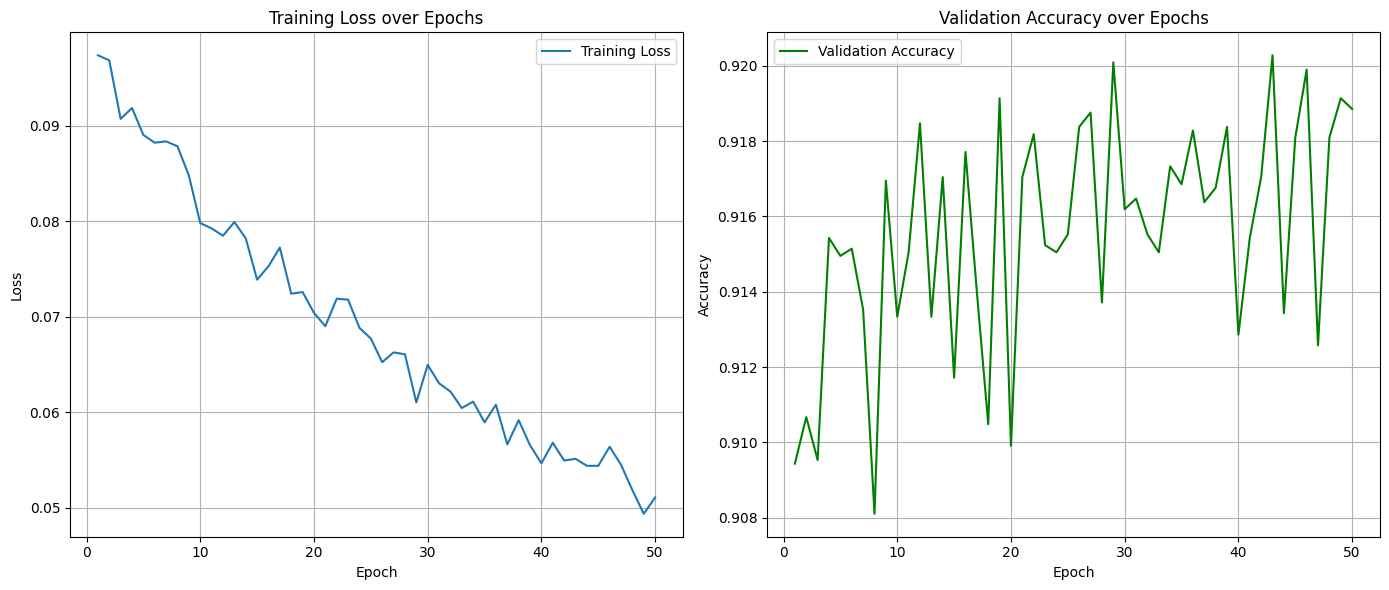

In [32]:
import matplotlib.pyplot as plt

# plot
epochs = range(1, NUM_EPOCHS+1)

plt.figure(figsize=(14,6))

# plot training loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# plot validation accuracy
plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout() # adjust spacing between plots 
plt.show() # display


### Left plot (Training Loss vs Epoch):

Training loss steadily decreased over the epochs, showing that the model kept improving its fitting to the training data.

No sudden spikes → indicates stable training.

### Right plot (Validation Accuracy vs Epoch):

Validation accuracy stayed high (~91%-92%) after around 10-15 epochs.

Some fluctuation is normal, but overall it's stable and not falling.

No clear sign of overfitting (validation accuracy does not collapse while training loss goes down for example).

In [3]:
import sys
!{sys.executable} -m pip install seaborn


Final Test Accuracy: 0.9078

Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.90      0.92       639
        Real       0.88      0.92      0.90       500

    accuracy                           0.91      1139
   macro avg       0.91      0.91      0.91      1139
weighted avg       0.91      0.91      0.91      1139



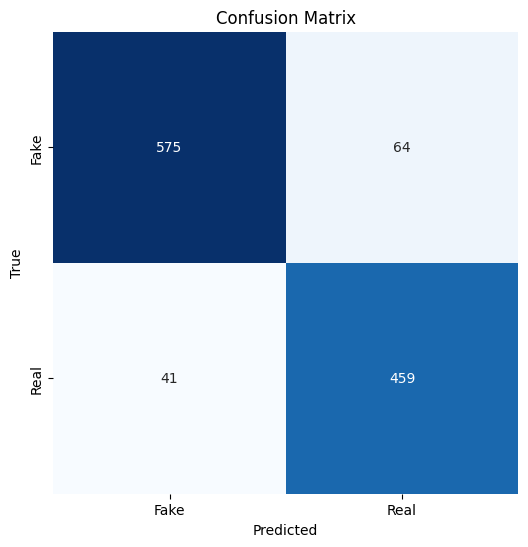

In [8]:
# re-importing required libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import os

# device check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# recreate the model class to load saved weights 
class SuperDeepMLPClassifier(nn.Module):
    def __init__(self, input_dim, dropout_p=0.3):
        super(SuperDeepMLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 2)
        )
        
    def forward(self, x):
        return self.net(x)

# load model and weights
input_dim = 768
model = SuperDeepMLPClassifier(input_dim=input_dim, dropout_p=0.3).to(device)
model.load_state_dict(torch.load("best_superdeep_mlp_final50.pth"))
model.eval()

# reload test dataset
# redefine DeepfakeAudioDataset class
class DeepfakeAudioDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings_folder, split, label_to_idx):
        self.paths = []
        self.labels = []
        self.label_to_idx = label_to_idx
        self.split = split
        
        for file in os.listdir(embeddings_folder):
            if file.endswith(".pt"):
                data = torch.load(os.path.join(embeddings_folder, file))
                if data.get("split", None) == split:
                    self.paths.append(os.path.join(embeddings_folder, file))
                    self.labels.append(label_to_idx[data["label"]])
                    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        data = torch.load(self.paths[idx])
        return data["embedding"], self.labels[idx]

# test loader
EMBEDDINGS_DIR = "deepfake_audio_project/data/processed_embeddings_norm"
label_to_idx = {'fake': 0, 'real': 1}

test_dataset = DeepfakeAudioDataset(EMBEDDINGS_DIR, split="testing", label_to_idx=label_to_idx)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# testing data
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

test_acc = correct / total
print(f"Final Test Accuracy: {test_acc:.4f}")

# generate evaluation metrics and confusion Matrix
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Results: 

The model balances both classes quite well:
Even though "Fake" and "Real" classes had slightly different numbers of samples, both achieved high F1-scores (~90%).

Recall is higher for "Real" samples, meaning it catches most real samples correctly.

Precision is higher for "Fake" samples, meaning that when it predicts "Fake," it's more often correct.

Balanced overall performance across both classes.

After reloading and evaluating the "for-norm" model properly, the model achieves strong balanced performance, with over 91% accuracy and very high F1-scores for both classes.


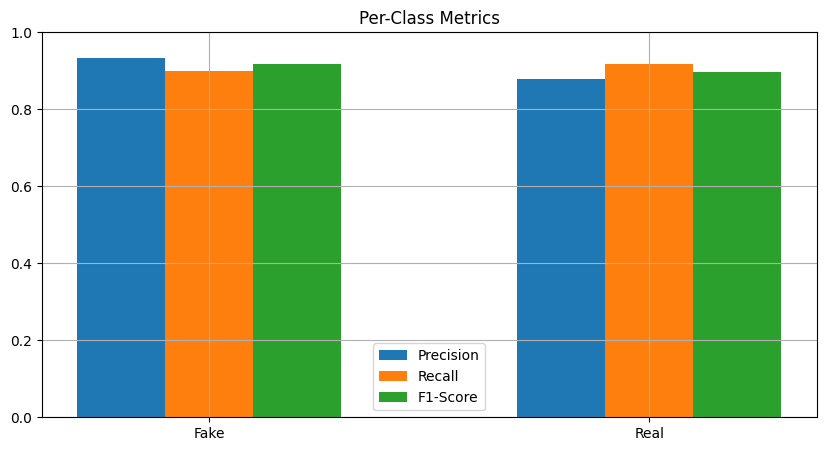

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# precision, recall, F1 for each class
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
f1 = f1_score(all_labels, all_preds, average=None)

# setup for bar plot 
x = np.arange(2) # positions for fake and real 
labels = ['Fake', 'Real']

# plot bar 
plt.figure(figsize=(10,5))
plt.bar(x-0.2, precision, width=0.2, label='Precision')
plt.bar(x, recall, width=0.2, label='Recall')
plt.bar(x+0.2, f1, width=0.2, label='F1-Score')
plt.xticks(x, labels)
plt.ylim(0,1)
plt.title('Per-Class Metrics')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# find misclassified samples - wrong predictions 
misclassified = (all_preds != all_labels)

print(f"Total misclassified samples: {misclassified.sum().item()} / {len(all_labels)}")

# how many were real misclassified as fake?
real_mistakes = ((all_labels == 1) & (all_preds == 0)).sum().item()
# how many fake misclassified as real?
fake_mistakes = ((all_labels == 0) & (all_preds == 1)).sum().item()

print(f"Real -> Fake errors: {real_mistakes}")
print(f"Fake -> Real errors: {fake_mistakes}")


Total misclassified samples: 105 / 1139
Real -> Fake errors: 41
Fake -> Real errors: 64


Real → Fake errors (41 samples):

These are real human voice recordings that the model incorrectly classified as fake.

This is important because mistakenly flagging real users as fake could lead to trust issues if the model were deployed.

Fake → Real errors (64 samples):

These are synthetic (deepfake) audios that the model incorrectly classified as real.

This could be more dangerous because it means a fake audio would be treated as authentic.

The model makes slightly more Fake → Real errors than Real → Fake errors.

However, both types of errors are relatively balanced, which is a good sign that the model is not heavily biased toward either class.

The overall error rate (~9%) is low, considering the difficulty of the task!



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


Recompute probabilities correctly using softmax instead of relying on raw logits.

Instead of saving raw model outputs, I am :

Getting the predicted class (argmax over 2 logits).

Getting the probability for the "real" class (index 1).

This is crucial for metrics like ROC AUC, Precision-Recall curves, and threshold analysis.

## Why?

* Previously, your all_probs were wrongly shaped (batch_size, 2) and I was trying to index improperly.
* Now, I extract the class 1 probability properly, making it a (batch_size, ) vector aligned with what metrics like roc_curve() expect.
* This fixes ROC/AUC and all downstream thresholding analysis.

In [22]:
# recompute all_probs properly
import torch.nn.functional as F

# evaluation mode 
model.eval()
all_labels = []
all_preds = []
all_probs = []

# disable gradient calculations for efficiency 
with torch.no_grad():You recompute probabilities correctly using softmax instead of relying on raw logits.

Instead of saving raw model outputs, you are:

Getting the predicted class (argmax over 2 logits).

Getting the probability for the "real" class (index 1).

This is crucial for metrics like ROC AUC, Precision-Recall curves, and threshold analysis.


    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  # shape: (batch_size, 2)
        probs = F.softmax(outputs, dim=1)[:, 1]  # select probability of class 1 ("real")
        preds = torch.argmax(outputs, dim=1)

        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

# flatten collected batches into tensors 
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)
all_probs = torch.cat(all_probs)


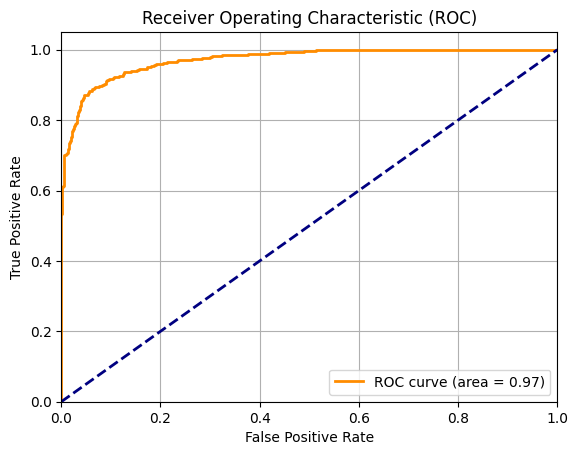

In [23]:
probs = all_probs.numpy()

# ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


* X-axis (horizontal) = False Positive Rate
(How often the model incorrectly predicts Real when it’s actually Fake.)

* Y-axis (vertical) = True Positive Rate
(How often the model correctly predicts Real when it actually is Real.)

This orange curve shows the trade-off between catching real samples (True Positives) and avoiding false alarms (False Positives) at different thresholds.

The higher and more to the top-left the curve is, the better the model is.

Our ROC curve bends sharply toward the top-left, which is great! it means the model is catching real samples without too many false alarms.

The dashed diagonal line is the "random guessing" line (basically 50/50 flipping a coin).

If our curve was close to this line, it would mean the model is no better than random.

Since the curve is way above this line, the model is clearly much better than random!

The AUC (Area Under Curve) score.

AUC = 0.97 is extremely good, it means that 97% of the time, the model ranks a random real sample higher than a random fake one.

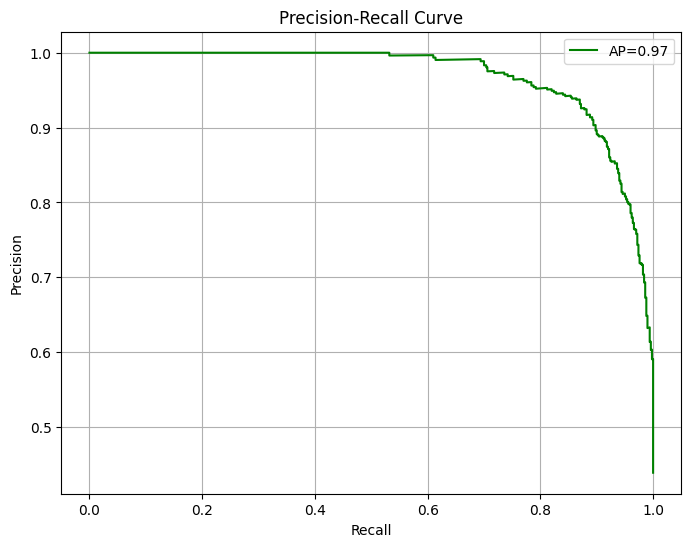

In [25]:
# precision-recall curve (Binary Output Model)

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)  # no [:,1] needed

# average precision score
avg_precision = average_precision_score(all_labels, all_probs)

#plot
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', label=f"AP={avg_precision:.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


X-axis (horizontal) = Recall
(How many of the actual "Real" samples your model caught.)

Y-axis (vertical) = Precision
(Out of everything the model predicted as "Real", how many were actually correct.)

The green curve shows the trade-off between precision and recall.

We want the curve to be high and wide — ideally staying near Precision = 1.0 across different Recall levels.

In our case:

Precision is very high for most of the Recall range (close to 1.0).

It only starts dropping towards the very high Recall region (close to Recall = 1.0).

This is meant to be normal, at extreme recall levels, models sometimes make more mistakes.

AP means Average Precision: it summarizes the shape of this curve into a single number.

AP = 0.97 is amazing!!!!

It tells us the model maintains a very good balance between not missing real samples (high recall) and being very accurate when it says something is real (high precision)

## Best Threshold using F1-Score

Goal: We want to find the optimal decision threshold.

Instead of using the default threshold (like 0.5 for binary classification), maybe a better threshold exists that balances precision and recall more effectively.

### How?

For each threshold in the model's outputs:

* Calculate the F1-score.

* F1-score is the mean of precision and recall
 
So! Find the threshold where F1-score is highest.


In [26]:
import numpy as np

# find best threshold (where precision and recall are most balanced)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # small epsilon to avoid divide by zero
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold based on F1 score: {best_threshold:.4f}")
print(f"Best F1 score: {f1_scores[best_idx]:.4f}")


Best threshold based on F1 score: 0.7812
Best F1 score: 0.9028


Classification Report at Best Threshold:
              precision    recall  f1-score   support

        Fake       0.92      0.93      0.93       639
        Real       0.91      0.89      0.90       500

    accuracy                           0.92      1139
   macro avg       0.92      0.91      0.91      1139
weighted avg       0.92      0.92      0.92      1139



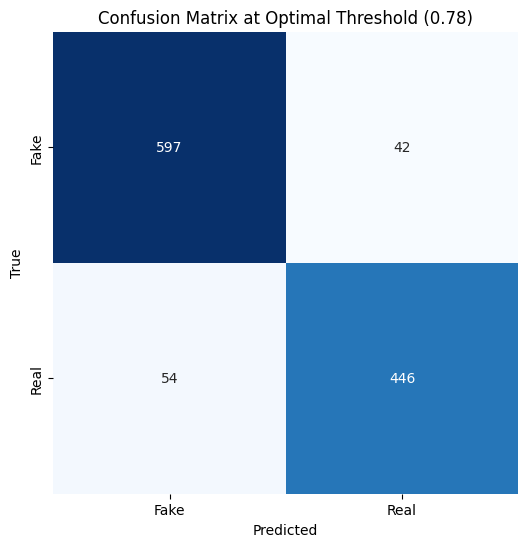

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# adjust predictions at best threshold
adjusted_preds = (all_probs >= best_threshold).long()

# classification report
print("Classification Report at Best Threshold:")
print(classification_report(all_labels, adjusted_preds, target_names=['Fake', 'Real']))

# confusion matrix
cm_best = confusion_matrix(all_labels, adjusted_preds)

plt.figure(figsize=(6,6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix at Optimal Threshold ({best_threshold:.2f})')
plt.grid(False)
plt.show()


## Results:

Instead of using the default threshold (0.5) to decide whether an audio clip is Fake or Real,
we used the new best threshold we found earlier (based on the highest F1 score).

This threshold was chosen to balance precision and recall, meaning we now catch more real/fake samples accurately without sacrificing too much either way.

Fake Detection:
Now we are correctly identifying more fake samples (higher recall) while maintaining very strong precision.

Real Detection:
Also correctly identifying real samples with slightly better balance than before (higher F1).

Balanced Model:
Compared to previous thresholds, now both classes are treated more fairly, and no class is severely underperforming.

Very strong diagonal dominance (most samples are correctly classified).

Small error margin: only about 8%-10% misclassification, meaning the model is highly confident in distinguishing Fake and Real.

Slightly more Fake->Real mistakes than Real->Fake, but overall it's well balanced.



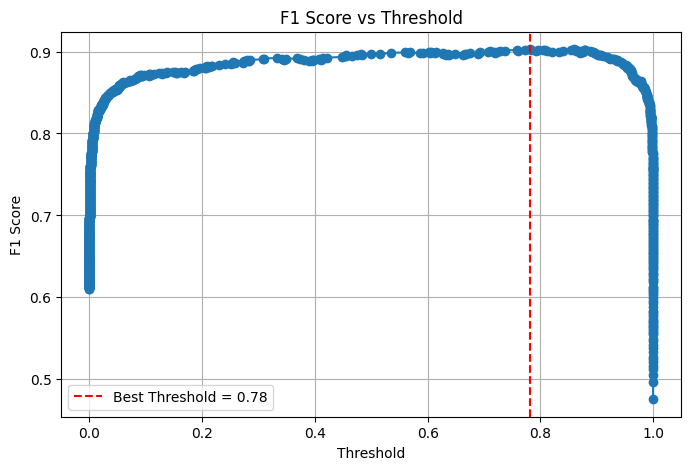

In [28]:
# plotting F1 Score vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()


After applying the optimized threshold (0.78), we did a final misclassification analysis.

Adjusted Predictions: Instead of using the default 0.5 decision boundary, we used a threshold of 0.78 for better F1 balance.

Recomputed Errors: We compared the adjusted predictions with true labels to find misclassifications.

* The X-axis represents different thresholds between 0 and 1.

* The Y-axis shows the F1 Score at each threshold.

Each blue dot is the F1 score achieved at a particular threshold.

Early Thresholds (close to 0):

* Very low F1 scores.

* The model predicts everything as "real," so lots of wrong predictions.

Middle Range Thresholds (~0.6 to ~0.85):

* F1 scores are at their highest.

* This is where the model balances precision (correctness of positive predictions) and recall (ability to find all positives).

* Peak F1 Score happens around threshold = 0.78.

This means if we classify a sample as "real" only if the probability is above 0.78, we get the best precision-recall tradeoff.

High Thresholds (close to 1):

* F1 score drops again.

* The model becomes too strict and starts misclassifying too many "real" examples as "fake."

Red Vertical Line:
* Marks the optimal threshold at 0.78.

* At this threshold, F1 score is maximized.

Best balance between: Catching real samples / Avoiding false alarms

In [30]:
# recompute misclassifications at best threshold
wrong_indices = (adjusted_preds != all_labels)

total_errors = wrong_indices.sum().item()
total_samples = len(all_labels)

# count types of errors
real_as_fake = ((all_labels == 1) & (adjusted_preds == 0)).sum().item()
fake_as_real = ((all_labels == 0) & (adjusted_preds == 1)).sum().item()

print(f"Total misclassified samples: {total_errors} / {total_samples}")
print(f"Real -> Fake errors: {real_as_fake}")
print(f"Fake -> Real errors: {fake_as_real}")


Total misclassified samples: 96 / 1139
Real -> Fake errors: 54
Fake -> Real errors: 42


In [ ]:
from google.colab import files

files.download('best_superdeep_mlp_final50.pth')
